In [1]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
from pathlib import Path

import datetime
import time
import os
import sys
import re 
from collections import Counter, defaultdict
from concurrent.futures import ProcessPoolExecutor, wait
from functools import partial
import mmap
import json
import pickle as pkl
import gc
import logging
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score,recall_score, average_precision_score, roc_curve,f1_score, auc, precision_recall_fscore_support,precision_recall_curve,accuracy_score,precision_score,mean_squared_error,mean_squared_error,mean_absolute_percentage_error
from xgboost.sklearn import XGBClassifier
import math
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.decomposition import PCA
from tqdm import tqdm
import shap



import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier



from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [2]:

dataSet = [[0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 1, 0, 1, 1],
            [0, 1, 1, 0, 1],
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0],
            [1, 0, 0, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 0, 1, 2, 1],
            [1, 0, 1, 2, 1],
            [2, 0, 1, 2, 1],
            [2, 0, 1, 1, 1],
            [2, 1, 0, 1, 1],
            [2, 1, 0, 2, 1],
            [2, 0, 0, 0, 0]]
labels = ['Age', 'Have_job', 'Have_house', 'Credits']


In [3]:
tr, ts = train_test_split(dataSet, test_size=0.20, random_state=42)
i = 0

In [4]:
tr = np.array(tr)
ts = np.array(ts)

In [5]:
print(tr[:,-1] )
print(ts[:,-1] )

[1 0 1 1 0 0 0 1 1 1 1 0]
[1 1 0]


In [6]:
i = 0

## SVM

In [7]:
def SVM_model(C,max_iter,tol):
    
    
    
    svm_model = svm.SVC(
        max_iter= int (max_iter),
                                    tol =  tol,
                                C= C,
                       probability = True,
                        kernel = 'linear'
                       )
    
    val = cross_val_score(svm_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 5,n_jobs = 10).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = SVM_model,pbounds = param_tune,verbose = 2,random_state = 1 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max

In [8]:
import sys

tr_dx = np.array(tr[:,:-1]).astype(float)
tr_dy = np.array(tr[:,-1]).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)


param_tune = {

        'max_iter': (1, 5000),
        'tol': (0.0001,1),
        'C': (1, 50)
                }
tm_st = time.time()
params = tune([i], nb = 10, nit = 20, model_name = 'SVM', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

svm_model = svm.SVC(
            max_iter= int (params['params']['max_iter']),
                                    tol =  params['params']['tol'],
                                C= params['params']['C'],
                       probability = True,
                        kernel = 'linear',decision_function_shape='ovr'
                       )

        
tm_st = time.time() 
svm_model.fit(tr_dx,tr_dy)
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)


tm_st = time.time()        
test_preds = svm_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)


preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)



recall = recall_score(ts_dy, preds_1, average='weighted')



precision = precision_score(ts_dy, preds_1, average='weighted')

        
f1_s = f1_score(ts_dy, preds_1, average='weighted')

print("Test recall: ",recall)
print("Test precision: ",precision)        
print("Test f1_s: ",f1_s)


current task: 0 SVM
|   iter    |  target   |     C     | max_iter  |    tol    |
-------------------------------------------------------------
| 1         | 1.0       | 21.43     | 3.602e+03 | 0.0002144 |
| 2         | 1.0       | 15.81     | 734.6     | 0.09243   |
| 3         | 1.0       | 10.13     | 1.728e+03 | 0.3968    |
| 4         | 1.0       | 27.4      | 2.097e+03 | 0.6853    |
| 5         | 1.0       | 11.02     | 4.391e+03 | 0.02748   |
| 6         | 1.0       | 48.05     | 12.41     | 0.6558    |
| 7         | 1.0       | 47.37     | 4.981e+03 | 0.9198    |
| 8         | 0.9       | 1.027     | 37.57     | 0.8557    |
| 9         | 1.0       | 16.11     | 736.8     | 0.3125    |
| 10        | 1.0       | 25.01     | 4.445e+03 | 0.5883    |
{'target': 1.0, 'params': {'C': 21.434078230426127, 'max_iter': 3601.9021427173484, 'tol': 0.00021436337986315216}}
Tuning:
1.8259928226470947
Training:
0.001055002212524414
Predicting:
0.0002903938293457031
Test accuracy:  1.0
Test rec

In [9]:
def SVM_model(C,max_iter,tol):
    
    
    
    svm_model = svm.SVC(
        max_iter= int (max_iter),
                                    tol =  tol,
                                C= C,
                       probability = True,
                        kernel = 'linear'
                       )
    
    val = cross_val_score(svm_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 2,n_jobs = 10).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = SVM_model,pbounds = param_tune,verbose = 2,random_state = 1 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max

    
dtr,_1, ltr,_2 = train_test_split(tr[:,:-1],tr[:,-1], test_size=0.5, random_state=42)

import sys

tr_dx = np.array(dtr).astype(float)
tr_dy = np.array(ltr).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)


param_tune = {

        'max_iter': (1, 5000),
        'tol': (0.0001,1),
        'C': (1, 50)
                }
tm_st = time.time()
params = tune([i], nb = 10, nit = 20, model_name = 'SVM', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

svm_model = svm.SVC(
            max_iter= int (params['params']['max_iter']),
                                    tol =  params['params']['tol'],
                                C= params['params']['C'],
                       probability = True,
                        kernel = 'linear',decision_function_shape='ovr'
                       )

        
tm_st = time.time() 
svm_model.fit(tr_dx,tr_dy)
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)


tm_st = time.time()        
test_preds = svm_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)


preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)

current task: 0 SVM
|   iter    |  target   |     C     | max_iter  |    tol    |
-------------------------------------------------------------
| 1         | 1.0       | 21.43     | 3.602e+03 | 0.0002144 |
| 2         | 1.0       | 15.81     | 734.6     | 0.09243   |
| 3         | 1.0       | 10.13     | 1.728e+03 | 0.3968    |
| 4         | 1.0       | 27.4      | 2.097e+03 | 0.6853    |
| 5         | 1.0       | 11.02     | 4.391e+03 | 0.02748   |
| 6         | 1.0       | 48.05     | 12.41     | 0.6558    |
| 7         | 1.0       | 47.37     | 4.981e+03 | 0.9198    |
| 8         | 1.0       | 1.027     | 37.57     | 0.8557    |
| 9         | 1.0       | 1.208     | 4.974e+03 | 0.7788    |
| 10        | 1.0       | 48.26     | 6.355     | 0.2601    |
{'target': 1.0, 'params': {'C': 21.434078230426127, 'max_iter': 3601.9021427173484, 'tol': 0.00021436337986315216}}
Tuning:
0.7046265602111816
Training:
0.0010235309600830078
Predicting:
0.0002167224884033203
Test accuracy:  0.333333333

In [10]:
def SVM_model(C,max_iter,tol):
    
    
    
    svm_model = svm.SVC(
        max_iter= int (max_iter),
                                    tol =  tol,
                                C= C,
                       probability = True,
                        kernel = 'sigmoid'
                       )
    
    val = cross_val_score(svm_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 5,n_jobs = 10).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = SVM_model,pbounds = param_tune,verbose = 2,random_state = 1 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max

In [11]:
import sys

tr_dx = np.array(tr[:,:-1]).astype(float)
tr_dy = np.array(tr[:,-1]).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)


param_tune = {

        'max_iter': (1, 5000),
        'tol': (0.0001,1),
        'C': (1, 50)
                }
tm_st = time.time()
params = tune(tasks = [i], nb = 10, nit = 20, model_name = 'SVM', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

svm_model = svm.SVC(
            max_iter= int (params['params']['max_iter']),
                                    tol =  params['params']['tol'],
                                C= params['params']['C'],
                       probability = True,
                        kernel = 'sigmoid'
                       )

        
tm_st = time.time() 
svm_model.fit(tr_dx,tr_dy)
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)


tm_st = time.time()        
test_preds = svm_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)


preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)



recall = recall_score(ts_dy, preds_1, average='weighted')



precision = precision_score(ts_dy, preds_1)

        
f1_s = f1_score(ts_dy, preds_1, average='weighted')

print("Test recall: ",recall)
print("Test precision: ",precision)        
print("Test f1_s: ",f1_s)

current task: 0 SVM
|   iter    |  target   |     C     | max_iter  |    tol    |
-------------------------------------------------------------
| 1         | 0.3333    | 21.43     | 3.602e+03 | 0.0002144 |
| 2         | 0.3333    | 15.81     | 734.6     | 0.09243   |
| 3         | 0.3333    | 10.13     | 1.728e+03 | 0.3968    |
| 4         | 0.3333    | 27.4      | 2.097e+03 | 0.6853    |
| 5         | 0.3333    | 11.02     | 4.391e+03 | 0.02748   |
| 6         | 0.3333    | 48.05     | 12.41     | 0.6558    |


/home/sun.chengkun/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=12).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 7         | 0.3333    | 47.37     | 4.981e+03 | 0.9198    |
| 8         | 0.5333    | 1.027     | 37.57     | 0.8557    |
| 9         | 0.3333    | 3.254     | 34.04     | 0.9013    |
| 10        | 0.3333    | 36.59     | 3.643e+03 | 0.1948    |
{'target': 0.5333333333333333, 'params': {'C': 1.0269457804101272, 'max_iter': 37.56701801163468, 'tol': 0.8557420217349458}}
Tuning:
0.6911904811859131
Training:
0.0011930465698242188
Predicting:
0.00025653839111328125
Test accuracy:  0.6666666666666666
Test recall:  0.6666666666666666
Test precision:  0.6666666666666666
Test f1_s:  0.5333333333333333


In [12]:
for para in [0.00001,0.5,1]:
    import sys

    tr_dx = np.array(tr[:,:-1]).astype(float)
    tr_dy = np.array(tr[:,-1]).astype(float)
    ts_dx = np.array(ts[:,:-1]).astype(float)
    ts_dy = np.array(ts[:,-1]).astype(float)



    svm_model = svm.SVC(
                                        tol =  para,
                           probability = True,
                            kernel = 'linear',decision_function_shape='ovr'
                           )


    tm_st = time.time() 
    svm_model.fit(tr_dx,tr_dy)
    tm_ed = time.time()
    print("Training:")
    print(tm_ed-tm_st)


    tm_st = time.time()        
    test_preds = svm_model.predict_proba(ts_dx)
    tm_ed = time.time()
    print("Predicting:")
    print(tm_ed-tm_st)


    preds_1 = test_preds.argmax(axis=1)
    ts_accuracy_score = accuracy_score(ts_dy, preds_1)
    print("Test accuracy: " ,ts_accuracy_score)


Training:
0.0007317066192626953
Predicting:
0.00022983551025390625
Test accuracy:  1.0
Training:
0.0003848075866699219
Predicting:
0.00010323524475097656
Test accuracy:  1.0
Training:
0.0003685951232910156
Predicting:
9.822845458984375e-05
Test accuracy:  1.0


In [13]:
for C in [1,25,50]:
    import sys

    tr_dx = np.array(tr[:,:-1]).astype(float)
    tr_dy = np.array(tr[:,-1]).astype(float)
    ts_dx = np.array(ts[:,:-1]).astype(float)
    ts_dy = np.array(ts[:,-1]).astype(float)



    svm_model = svm.SVC(
                                        C =  para,
                           probability = True,
                            kernel = 'linear',decision_function_shape='ovr'
                           )


    tm_st = time.time() 
    svm_model.fit(tr_dx,tr_dy)
    tm_ed = time.time()
    print("Training:")
    print(tm_ed-tm_st)


    tm_st = time.time()        
    test_preds = svm_model.predict_proba(ts_dx)
    tm_ed = time.time()
    print("Predicting:")
    print(tm_ed-tm_st)


    preds_1 = test_preds.argmax(axis=1)
    ts_accuracy_score = accuracy_score(ts_dy, preds_1)
    print("Test accuracy: " ,ts_accuracy_score)

Training:
0.0006108283996582031
Predicting:
0.00023794174194335938
Test accuracy:  1.0
Training:
0.0004456043243408203
Predicting:
0.00011372566223144531
Test accuracy:  1.0
Training:
0.00043129920959472656
Predicting:
0.00011205673217773438
Test accuracy:  1.0


In [14]:
for para in [200,2000,5000]:
    import sys

    tr_dx = np.array(tr[:,:-1]).astype(float)
    tr_dy = np.array(tr[:,-1]).astype(float)
    ts_dx = np.array(ts[:,:-1]).astype(float)
    ts_dy = np.array(ts[:,-1]).astype(float)



    svm_model = svm.SVC(
                                        max_iter =  para,
                           probability = True,
                            kernel = 'linear',decision_function_shape='ovr'
                           )


    tm_st = time.time() 
    svm_model.fit(tr_dx,tr_dy)
    tm_ed = time.time()
    print("Training:")
    print(tm_ed-tm_st)


    tm_st = time.time()        
    test_preds = svm_model.predict_proba(ts_dx)
    tm_ed = time.time()
    print("Predicting:")
    print(tm_ed-tm_st)


    preds_1 = test_preds.argmax(axis=1)
    ts_accuracy_score = accuracy_score(ts_dy, preds_1)
    print("Test accuracy: " ,ts_accuracy_score)

Training:
0.0005750656127929688
Predicting:
0.0001316070556640625
Test accuracy:  1.0
Training:
0.00044226646423339844
Predicting:
0.00011277198791503906
Test accuracy:  1.0
Training:
0.0004329681396484375
Predicting:
0.00011110305786132812
Test accuracy:  1.0


## KNN

In [15]:
def xgb_cv(n_neighbors):
    
    
    
    xgb_model = KNeighborsClassifier(n_neighbors = int(n_neighbors),
                              
                             )
    
    val = cross_val_score(xgb_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 2,n_jobs = 30).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = xgb_cv,pbounds = param_tune,verbose = 2,random_state = 777 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max
    
from sklearn.neighbors import KNeighborsClassifier


dtr,_1, ltr,_2 = train_test_split(tr[:,:-1],tr[:,-1], test_size=0.5, random_state=42)

import sys

tr_dx = np.array(dtr).astype(float)
tr_dy = np.array(ltr).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)




param_tune = {
            'n_neighbors' :(1,3)

                }




tm_st = time.time()
params = tune(tasks = [i], nb = 10, nit = 20, model_name = 'XG', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

kn_model = KNeighborsClassifier(n_neighbors = int(params['params']['n_neighbors']))

        
tm_st = time.time()
kn_model.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = kn_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)



preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)

current task: 0 XG
|   iter    |  target   | n_neig... |
-------------------------------------
| 1         | 0.8333    | 1.305     |
| 2         | 0.8333    | 1.605     |
| 3         | 0.8333    | 1.124     |
| 4         | 0.8333    | 1.92      |
| 5         | 0.6667    | 2.671     |
| 6         | 0.8333    | 1.0       |
| 7         | 0.8333    | 1.782     |
| 8         | 0.8333    | 1.457     |
| 9         | 0.8333    | 1.86      |
| 10        | 0.8333    | 1.214     |
{'target': 0.8333333333333333, 'params': {'n_neighbors': 1.305327469802644}}
Tuning:
4.709112882614136
Training:
0.0008070468902587891
Predicting:
0.0007531642913818359
Test accuracy:  0.3333333333333333


In [16]:
def xgb_cv(n_neighbors):
    
    
    
    xgb_model = KNeighborsClassifier(n_neighbors = int(n_neighbors),
                              
                             )
    
    val = cross_val_score(xgb_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 5,n_jobs = 30).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = xgb_cv,pbounds = param_tune,verbose = 2,random_state = 777 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max

In [17]:
from sklearn.neighbors import KNeighborsClassifier


import sys

tr_dx = np.array(tr[:,:-1]).astype(float)
tr_dy = np.array(tr[:,-1]).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)


param_tune = {
            'n_neighbors' :(1,10)

                }




tm_st = time.time()
params = tune(tasks = [i], nb = 10, nit = 20, model_name = 'XG', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

kn_model = KNeighborsClassifier(n_neighbors = int(params['params']['n_neighbors']))

        
tm_st = time.time()
kn_model.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = kn_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)



preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)



recall = recall_score(ts_dy, preds_1, average='weighted')



precision = precision_score(ts_dy, preds_1, average='weighted')

        
f1_s = f1_score(ts_dy, preds_1, average='weighted')

print("Test recall: ",recall)
print("Test precision: ",precision)        
print("Test f1_s: ",f1_s)


current task: 0 XG
|   iter    |  target   | n_neig... |
-------------------------------------
| 1         | 0.7333    | 2.374     |
| 2         | 0.9333    | 3.721     |
| 3         | 0.9333    | 1.558     |
| 4         | 0.7333    | 5.139     |
| 5         | 0.7       | 8.517     |
| 6         | 0.9333    | 1.558     |
| 7         | 0.6667    | 4.121     |
| 8         | 0.9333    | 3.512     |
| 9         | 0.9333    | 1.18      |
| 10        | 0.7333    | 6.805     |
{'target': 0.9333333333333332, 'params': {'n_neighbors': 3.721209487367691}}
Tuning:
1.450364351272583
Training:
0.0006647109985351562
Predicting:
0.0007734298706054688
Test accuracy:  1.0
Test recall:  1.0
Test precision:  1.0
Test f1_s:  1.0


## MLP

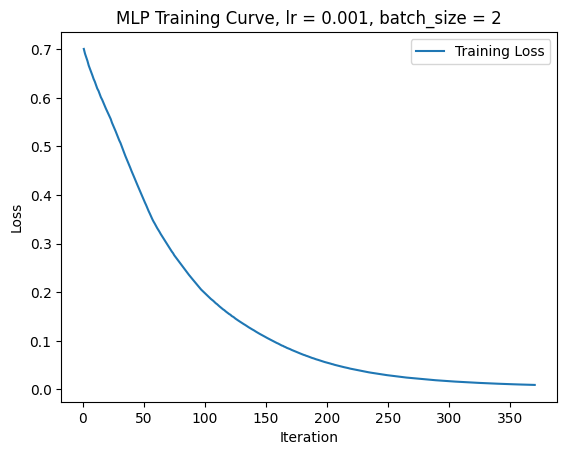

Training:
0.41089415550231934
Predicting:
0.00031566619873046875
Test accuracy:  0.3333333333333333
Train accuracy 1.0


In [18]:
dtr,_1, ltr,_2 = train_test_split(tr[:,:-1],tr[:,-1], test_size=0.5, random_state=42)

import sys

tr_dx = np.array(dtr).astype(float)
tr_dy = np.array(ltr).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)



mlp = MLPClassifier(activation = "relu",solver = "adam", batch_size = 2, learning_rate_init = 0.001, hidden_layer_sizes=(20, 10), max_iter=2000, random_state=42)


mlp.fit(tr_dx, tr_dy)


iterations = range(1, len(mlp.loss_curve_) + 1)
loss_values = mlp.loss_curve_


plt.figure()
plt.title("MLP Training Curve, lr = 0.001, batch_size = 2")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(iterations, loss_values, label="Training Loss")
plt.legend()
plt.show()


tm_st = time.time()
mlp.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = mlp.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)



preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)

tr_preds = mlp.predict_proba(tr_dx)
tr_res = tr_preds.argmax(axis=1)
tr_accuracy_score = accuracy_score(tr_dy, tr_res)
print("Train accuracy", tr_accuracy_score)

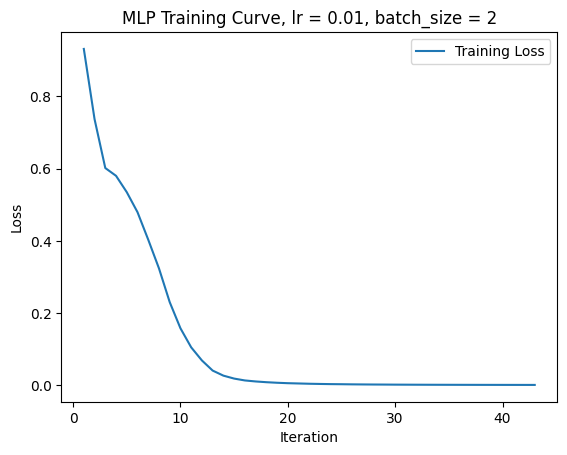

Training:
0.09334063529968262
Predicting:
0.00028443336486816406
Test accuracy:  1.0
Test recall:  1.0
Test precision:  1.0
Test f1_s:  1.0


In [19]:
import sys

tr_dx = np.array(tr[:,:-1]).astype(float)
tr_dy = np.array(tr[:,-1]).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)



mlp = MLPClassifier(activation = "relu",solver = "adam", batch_size = 2, learning_rate_init = 0.01, hidden_layer_sizes=(20, 10), max_iter=200, random_state=42)


mlp.fit(tr_dx, tr_dy)


iterations = range(1, len(mlp.loss_curve_) + 1)
loss_values = mlp.loss_curve_


plt.figure()
plt.title("MLP Training Curve, lr = 0.01, batch_size = 2")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(iterations, loss_values, label="Training Loss")
plt.legend()
plt.show()


tm_st = time.time()
mlp.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = mlp.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)



preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)



recall = recall_score(ts_dy, preds_1, average='weighted')



precision = precision_score(ts_dy, preds_1, average='weighted')

        
f1_s = f1_score(ts_dy, preds_1, average='weighted')

print("Test recall: ",recall)
print("Test precision: ",precision)        
print("Test f1_s: ",f1_s)


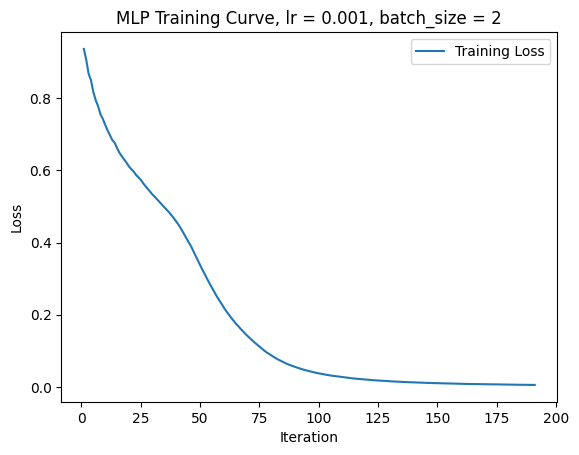

Training:
0.4290502071380615
Predicting:
0.0003147125244140625
Test accuracy:  1.0
Test recall:  1.0
Test precision:  1.0
Test f1_s:  1.0


In [20]:
import sys

tr_dx = np.array(tr[:,:-1]).astype(float)
tr_dy = np.array(tr[:,-1]).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)



mlp = MLPClassifier(activation = "relu",solver = "adam", batch_size = 2, learning_rate_init = 0.001, hidden_layer_sizes=(20, 10), max_iter=200, random_state=42)


mlp.fit(tr_dx, tr_dy)


iterations = range(1, len(mlp.loss_curve_) + 1)
loss_values = mlp.loss_curve_


plt.figure()
plt.title("MLP Training Curve, lr = 0.001, batch_size = 2")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(iterations, loss_values, label="Training Loss")
plt.legend()
plt.show()


tm_st = time.time()
mlp.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = mlp.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)



preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)



recall = recall_score(ts_dy, preds_1, average='weighted')



precision = precision_score(ts_dy, preds_1, average='weighted')

        
f1_s = f1_score(ts_dy, preds_1, average='weighted')

print("Test recall: ",recall)
print("Test precision: ",precision)        
print("Test f1_s: ",f1_s)


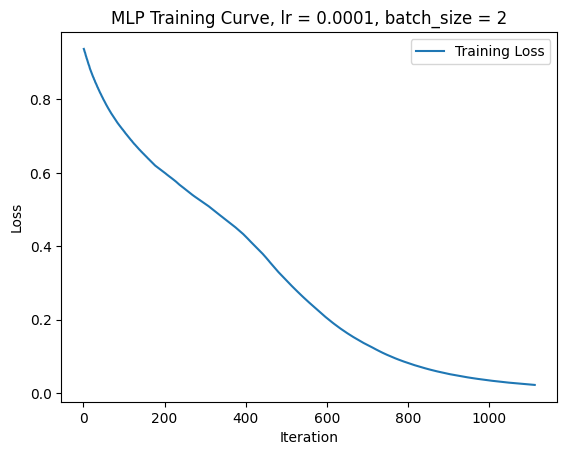

Training:
2.4752302169799805
Predicting:
0.0006840229034423828
Test accuracy:  1.0
Test recall:  1.0
Test precision:  1.0
Test f1_s:  1.0


In [21]:
import sys

tr_dx = np.array(tr[:,:-1]).astype(float)
tr_dy = np.array(tr[:,-1]).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)



mlp = MLPClassifier(activation = "relu",solver = "adam", batch_size = 2, learning_rate_init = 0.0001, hidden_layer_sizes=(20, 10), max_iter=2000, random_state=42)


mlp.fit(tr_dx, tr_dy)


iterations = range(1, len(mlp.loss_curve_) + 1)
loss_values = mlp.loss_curve_


plt.figure()
plt.title("MLP Training Curve, lr = 0.0001, batch_size = 2")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(iterations, loss_values, label="Training Loss")
plt.legend()
plt.show()


tm_st = time.time()
mlp.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = mlp.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)



preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)



recall = recall_score(ts_dy, preds_1, average='weighted')



precision = precision_score(ts_dy, preds_1, average='weighted')

        
f1_s = f1_score(ts_dy, preds_1, average='weighted')

print("Test recall: ",recall)
print("Test precision: ",precision)        
print("Test f1_s: ",f1_s)


## XGBoost

In [22]:
def xgb_cv(n_estimators,gamma, max_depth,min_child_weight):
    
    
    
    xgb_model = XGBClassifier(max_depth = int(max_depth), 
                              n_estimators = int(n_estimators) ,
                              objective = 'binary:logistic',
                                booster = 'gbtree', 
                              gamma = min(gamma,1),
                              min_child_weight = min(min_child_weight,1),
                              random_state = 77)
                              #scale_pos_weight = min(scale_pos_weight,1),random_state = 77,decision_function_shape='ovr' )
    
    val = cross_val_score(xgb_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 5,n_jobs = 10).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = xgb_cv,pbounds = param_tune,verbose = 2,random_state = 777 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max

In [23]:
def xgb_cv(n_estimators,gamma, max_depth,min_child_weight):
    
    
    
    xgb_model = XGBClassifier(max_depth = int(max_depth), 
                              n_estimators = int(n_estimators) ,
                              objective = 'binary:logistic',
                                booster = 'gbtree', 
                              gamma = min(gamma,1),
                              min_child_weight = min(min_child_weight,1),
                              random_state = 77)
                              #scale_pos_weight = min(scale_pos_weight,1),random_state = 77,decision_function_shape='ovr' )
    
    val = cross_val_score(xgb_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 2,n_jobs = 10).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = xgb_cv,pbounds = param_tune,verbose = 2,random_state = 777 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max
    
dtr,_1, ltr,_2 = train_test_split(tr[:,:-1],tr[:,-1], test_size=0.5, random_state=42)

import sys

tr_dx = np.array(dtr).astype(float)
tr_dy = np.array(ltr).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)




param_tune = {


            'max_depth' :(1,10),
            'n_estimators' :(1,50),

            'gamma': (0,1), 
            'min_child_weight' : (0,1)
                }




tm_st = time.time()
params = tune(tasks = [i], nb = 10, nit = 20, model_name = 'XG', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

xgb_model = XGBClassifier(max_depth = int(params['params']['max_depth']),
                                  
                                  n_estimators = int(params['params']['n_estimators']), 
                                  objective = 'binary:logistic',
                                 booster = 'gbtree', 
                                  gamma = params['params']['gamma'], 
                                  min_child_weight = params['params']['min_child_weight'],
                                  #scale_pos_weight= params['params']['scale_pos_weight'],
                                 random_state = 77)

        
tm_st = time.time()
xgb_model.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = xgb_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)


preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)


current task: 0 XG
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
| 1         | 1.0       | 0.1527    | 3.721     | 0.06204   | 23.53     |
| 2         | 0.6667    | 0.8353    | 9.343     | 0.727     | 38.66     |
| 3         | 1.0       | 0.2692    | 6.796     | 0.09337   | 4.905     |
| 4         | 0.6667    | 0.5896    | 4.09      | 0.9889    | 31.7      |
| 5         | 0.6667    | 0.6818    | 5.97      | 0.2689    | 19.29     |
| 6         | 0.6667    | 0.08175   | 6.45      | 0.252     | 4.587     |
| 7         | 0.6667    | 0.2251    | 5.153     | 0.5648    | 4.008     |
| 8         | 0.6667    | 0.3508    | 3.11      | 0.7111    | 5.439     |
| 9         | 0.6667    | 0.6863    | 8.563     | 0.6988    | 19.99     |
| 10        | 0.6667    | 0.3395    | 8.602     | 0.5182    | 42.54     |
{'target': 1.0, 'params': {'gamma': 0.152663734901322, 'max_depth': 3.721209487367691, 'min_c

In [24]:
import sys

tr_dx = np.array(tr[:,:-1]).astype(float)
tr_dy = np.array(tr[:,-1]).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)




param_tune = {


            'max_depth' :(1,10),
            'n_estimators' :(1,50),

            'gamma': (0,1), 
            'min_child_weight' : (0,1)
                }




tm_st = time.time()
params = tune(tasks = [i], nb = 10, nit = 20, model_name = 'XG', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

xgb_model = XGBClassifier(max_depth = int(params['params']['max_depth']),
                                  
                                  n_estimators = int(params['params']['n_estimators']), 
                                  objective = 'binary:logistic',
                                 booster = 'gbtree', 
                                  gamma = params['params']['gamma'], 
                                  min_child_weight = params['params']['min_child_weight'],
                                  #scale_pos_weight= params['params']['scale_pos_weight'],
                                 random_state = 77)

        
tm_st = time.time()
xgb_model.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = xgb_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)


preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)



recall = recall_score(ts_dy, preds_1, average='weighted')



precision = precision_score(ts_dy, preds_1, average='weighted')

        
f1_s = f1_score(ts_dy, preds_1, average='weighted')

print("Test recall: ",recall)
print("Test precision: ",precision)        
print("Test f1_s: ",f1_s)

current task: 0 XG
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
| 1         | 1.0       | 0.1527    | 3.721     | 0.06204   | 23.53     |
| 2         | 0.4167    | 0.8353    | 9.343     | 0.727     | 38.66     |
| 3         | 1.0       | 0.2692    | 6.796     | 0.09337   | 4.905     |
| 4         | 0.4167    | 0.5896    | 4.09      | 0.9889    | 31.7      |
| 5         | 0.75      | 0.6818    | 5.97      | 0.2689    | 19.29     |
| 6         | 1.0       | 0.349     | 6.872     | 0.01571   | 1.186     |
| 7         | 0.4167    | 0.0       | 1.0       | 1.0       | 2.793     |
| 8         | 1.0       | 0.4721    | 9.878     | 0.0       | 3.106     |
| 9         | 0.75      | 1.0       | 10.0      | 0.0       | 9.283     |
| 10        | 1.0       | 0.0       | 1.0       | 0.0       | 20.92     |
{'target': 1.0, 'params': {'gamma': 0.152663734901322, 'max_depth': 3.721209487367691, 'min_c

In [25]:
for para in [10,50,100]:
    
    import sys

    tr_dx = np.array(tr[:,:-1]).astype(float)
    tr_dy = np.array(tr[:,-1]).astype(float)
    ts_dx = np.array(ts[:,:-1]).astype(float)
    ts_dy = np.array(ts[:,-1]).astype(float)




    xgb_model = XGBClassifier(

                                      n_estimators = para, 
                                      objective = 'binary:logistic',
                                     booster = 'gbtree', 


                                     random_state = 77)


    tm_st = time.time()
    xgb_model.fit(tr_dx,tr_dy)     
    tm_ed = time.time()
    print("Training:")
    print(tm_ed-tm_st)

    tm_st = time.time()
    test_preds = xgb_model.predict_proba(ts_dx)
    tm_ed = time.time()
    print("Predicting:")
    print(tm_ed-tm_st)


    preds_1 = test_preds.argmax(axis=1)
    ts_accuracy_score = accuracy_score(ts_dy, preds_1)
    print("Test accuracy: " ,ts_accuracy_score)


Training:
1.3890440464019775
Predicting:
0.024637460708618164
Test accuracy:  0.3333333333333333
Training:
5.385335683822632
Predicting:
0.03632545471191406
Test accuracy:  0.3333333333333333
Training:
10.528843402862549
Predicting:
0.03392457962036133
Test accuracy:  0.3333333333333333


In [26]:
for para in [5,10,20]:
    
    import sys

    tr_dx = np.array(tr[:,:-1]).astype(float)
    tr_dy = np.array(tr[:,-1]).astype(float)
    ts_dx = np.array(ts[:,:-1]).astype(float)
    ts_dy = np.array(ts[:,-1]).astype(float)




    xgb_model = XGBClassifier(

                                      max_depth = para, 
                                      objective = 'binary:logistic',
                                     booster = 'gbtree', 


                                     random_state = 77)


    tm_st = time.time()
    xgb_model.fit(tr_dx,tr_dy)     
    tm_ed = time.time()
    print("Training:")
    print(tm_ed-tm_st)

    tm_st = time.time()
    test_preds = xgb_model.predict_proba(ts_dx)
    tm_ed = time.time()
    print("Predicting:")
    print(tm_ed-tm_st)


    preds_1 = test_preds.argmax(axis=1)
    ts_accuracy_score = accuracy_score(ts_dy, preds_1)
    print("Test accuracy: " ,ts_accuracy_score)

Training:
10.61658239364624
Predicting:
0.029973745346069336
Test accuracy:  0.3333333333333333
Training:
10.767698287963867
Predicting:
0.033426761627197266
Test accuracy:  0.3333333333333333
Training:
10.543903589248657
Predicting:
0.031400442123413086
Test accuracy:  0.3333333333333333


## DT

In [27]:
def xgb_cv(max_depth):
    
    
    
    xgb_model = DecisionTreeClassifier(max_depth = int(max_depth), 
                              #max_leaf_nodes = int(max_leaf_nodes),
                              
                             )
    
    val = cross_val_score(xgb_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 5,n_jobs = 30).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = xgb_cv,pbounds = param_tune,verbose = 2,random_state = 777 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max

In [28]:
def xgb_cv(max_depth):
    
    
    
    xgb_model = DecisionTreeClassifier(max_depth = int(max_depth), 
                              #max_leaf_nodes = int(max_leaf_nodes),
                              
                             )
    
    val = cross_val_score(xgb_model,tr_dx,tr_dy,scoring = 'accuracy',cv = 2,n_jobs = 30).mean()

    return val


def tune( tasks, nb, nit, model_name, param_tune):
    for task in tasks:
        print(f"current task: {task} {model_name}")
        #res_output = f"{task}year_{model_name}.txt"
        #model_dump = f"{task}year_{model_name}_model.pkl"
        


        
        BO = BayesianOptimization( f = xgb_cv,pbounds = param_tune,verbose = 2,random_state = 777 )
        
        BO.maximize(n_iter=5)
        print(BO.max)
        return BO.max
    
    
    
dtr,_1, ltr,_2 = train_test_split(tr[:,:-1],tr[:,-1], test_size=0.5, random_state=42)

import sys

tr_dx = np.array(dtr).astype(float)
tr_dy = np.array(ltr).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)




param_tune = {
            'max_depth' :(1,20),
            #'min_samples_split' : (2,10),
            #'min_samples_leaf' : (1,100), 
            #'max_leaf_nodes' :(2,100),

                }




tm_st = time.time()
params = tune(tasks = [i], nb = 10, nit = 20, model_name = 'XG', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

dt_model = DecisionTreeClassifier(max_depth = int(params['params']['max_depth']),
                                  #min_samples_split = int(params['params']['min_samples_split']), 
                                  #min_samples_leaf = params['params']['min_samples_leaf'], 
                                  #max_leaf_nodes = int(params['params']['max_leaf_nodes']),
                                 random_state = 77)

        
tm_st = time.time()
dt_model.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = dt_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)
preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)


        


current task: 0 XG
|   iter    |  target   | max_depth |
-------------------------------------
| 1         | 1.0       | 3.901     |
| 2         | 1.0       | 6.745     |
| 3         | 0.8333    | 2.179     |
| 4         | 1.0       | 9.737     |
| 5         | 1.0       | 16.87     |
| 6         | 0.8333    | 3.9       |
| 7         | 1.0       | 7.536     |
| 8         | 1.0       | 15.08     |
| 9         | 1.0       | 3.9       |
| 10        | 1.0       | 6.745     |
{'target': 1.0, 'params': {'max_depth': 3.9006109631251182}}
Tuning:
4.112292528152466
Training:
0.001352548599243164
Predicting:
0.00021600723266601562
Test accuracy:  0.3333333333333333


In [29]:
import sys

tr_dx = np.array(tr[:,:-1]).astype(float)
tr_dy = np.array(tr[:,-1]).astype(float)
ts_dx = np.array(ts[:,:-1]).astype(float)
ts_dy = np.array(ts[:,-1]).astype(float)




param_tune = {
            'max_depth' :(1,20),
            #'min_samples_split' : (2,10),
            #'min_samples_leaf' : (1,100), 
            #'max_leaf_nodes' :(2,100),

                }




tm_st = time.time()
params = tune(tasks = [i], nb = 10, nit = 20, model_name = 'XG', param_tune = param_tune)
tm_ed = time.time()
print("Tuning:")
print(tm_ed-tm_st)

dt_model = DecisionTreeClassifier(max_depth = int(params['params']['max_depth']),
                                  #min_samples_split = int(params['params']['min_samples_split']), 
                                  #min_samples_leaf = params['params']['min_samples_leaf'], 
                                  #max_leaf_nodes = int(params['params']['max_leaf_nodes']),
                                 random_state = 77)

        
tm_st = time.time()
dt_model.fit(tr_dx,tr_dy)     
tm_ed = time.time()
print("Training:")
print(tm_ed-tm_st)

tm_st = time.time()
test_preds = dt_model.predict_proba(ts_dx)
tm_ed = time.time()
print("Predicting:")
print(tm_ed-tm_st)
preds_1 = test_preds.argmax(axis=1)
ts_accuracy_score = accuracy_score(ts_dy, preds_1)
print("Test accuracy: " ,ts_accuracy_score)



recall = recall_score(ts_dy, preds_1, average='weighted')



precision = precision_score(ts_dy, preds_1, average='weighted')

        
f1_s = f1_score(ts_dy, preds_1, average='weighted')

print("Test recall: ",recall)
print("Test precision: ",precision)        
print("Test f1_s: ",f1_s)

        
        


current task: 0 XG
|   iter    |  target   | max_depth |
-------------------------------------
| 1         | 1.0       | 3.901     |
| 2         | 1.0       | 6.745     |
| 3         | 1.0       | 2.179     |
| 4         | 1.0       | 9.737     |
| 5         | 1.0       | 16.87     |
| 6         | 1.0       | 19.99     |
| 7         | 1.0       | 20.0      |
| 8         | 0.8333    | 1.001     |
| 9         | 1.0       | 5.356     |
| 10        | 1.0       | 8.286     |
{'target': 1.0, 'params': {'max_depth': 3.9006109631251182}}
Tuning:
2.3316760063171387
Training:
0.004071235656738281
Predicting:
0.00018286705017089844
Test accuracy:  1.0
Test recall:  1.0
Test precision:  1.0
Test f1_s:  1.0
